In [34]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [108]:
class Snake(gym.Env):
    def __init__(self):
        self.action_space = spaces.Discrete(3, start=-1)  # {-1: 'Left', 0: 'Straight', 1: 'Right'}
        
        # [head loc x, head loc y, food loc x, food loc y, danger left, danger straight, danger right]
        # for each grid loc there is either head, tail, food or nothing
        self.observation_space = spaces.MultiDiscrete([4] * 10 * 10) # {0: 'Nothing', 1: 'food', 2: 'tail', 3: 'head'}
        
        self.state = [0] * 10 * 10
        self.state[40:43] = [2,2,3]
        self.state[47] = 1
        self.done = False
        
        self._state_lag = None
        self._snake = [40,41,42]

    def step(self, action):
        """
        This method applies an action and returns the next state, reward, done, and any additional info.
        
        :param action: Action taken by the agent
        :return: tuple (next_state, reward, done, info)
        """
        self.done, self.state, food_eaten = self._update_state(action)
        
        # Give reward only if food is eaten
        if food_eaten:
            reward = 1
        elif self.done:
            reward = -1
        else:
            reward = 0

        info = {} # TODO - maybe add a rolling score for the game or other info
        
        return self.state, reward, self.done, info

    def reset(self):
        """
        This method resets the environment to its initial state.
        :return: Initial state
        """
        self.state = [0] * 10 * 10
        self.state[40:43] = [2,2,3]
        self.state[47] = 1
        self.done = False
        
        return self.state

    def render(self, mode='human'):
        """
        This method renders the environment. Can be visual, textual, or any other form of rendering.
        
        :param mode: Mode of rendering (e.g., 'human' for a human-readable format)
        """
        print(f"State: {self.state}")

    def close(self):
        """
        Any cleanup code for the environment can be added here (e.g., closing windows).
        """
        pass
    
    def _update_state(self, action: spaces.Discrete(3, start=-1)) -> (bool, spaces.MultiDiscrete([4] * 10 * 10), bool):
        """
        Sse self.state and self._state_lag to figure out the next state
        """
        head = self.state.index(3)
        if self._state_lag:
            head_lag = self._state_lag.index(3)
        else:
            head_lag = head - 1 # snake always start moving right
        food_index = self.state.index(1)
        
        
        head_change = head - head_lag
        # head_change = +/- 1 => snake moving right / left
        # head_change = +/- 10 => snake moving down / up
        
        direction_action_tuple = (head_change, action)
        head_lag = head
        if direction_action_tuple in [(1, 1), (-1, -1), (10, 0)]:
            # head moves down
            head += 10
        elif direction_action_tuple in [(-10, 1), (10, -1), (1, 0)]:
            # head moves right
            head += 1
        elif direction_action_tuple in [(10, 1), (-10, -1), (-1, 0)]:
            # head moves left
            head -= 1
        elif direction_action_tuple in [(-1, 1), (1, -1), (-10, 0)]:
            # head moves up
            head -= 10
            
        # update the snake positions
        self._snake.append(head)
        
        
        food_eaten = False
        if food_index == head: 
            food_eaten = True
            food_index = self._generate_new_food()
        else:
            self._snake.pop(0)
        
        done = self._terminal_reached() 
        # create new game state
        new_state = [0] * 10 * 10
        new_state[food_index] = 1
        for i in self._snake[0:-1]:
            new_state[i] = 2
        new_state[head] = 3
        
        self._state_lag = self.state 
        
        return done, new_state, food_eaten
    
    def _generate_new_food(self):
        valid_locations = [i for i in range(10*10) if i not in self._snake]
        
        return np.random.choice(valid_locations)
    
    def _terminal_reached(self) -> bool:
        """
        Method to figure out if an action results in a terminal action
        """      
        if self._snake[-2] % 10 == 0 and self._snake[-2] - self._snake[-1] == 1:
            # leftmost wall has been hit
            return True
        elif (self._snake[-2] + 1) % 10 == 0 and self._snake[-1] - self._snake[-2] == 1:
            # rightmost wall has been hit
            return True
        elif self._snake[-1] < 0 or self._snake[-1] >= 100:
            # either upper or lower most wall has been hit
            return True
        elif self._snake[-1] in self._snake[:-1]:
            return True
        
        return False

    


In [102]:
snake = Snake()

In [35]:
def visualize_game_state(state):
    if len(state) != 100:
        raise ValueError("State list must have a length of 100.")
    
    # Map the state list to a 10x10 grid
    grid = np.array(state).reshape(10, 10)
    
    # Define colors for each state
    cmap = ListedColormap(['white', 'green', 'blue', 'red'])  # Corresponds to 0, 1, 2, 3
    
    # Plot the grid
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(grid, cmap=cmap, aspect='equal')
    
    # Set up the gridlines and labels
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Annotate cells (optional, for debugging)
    for i in range(10):
        for j in range(10):
            ax.text(j, i, int(grid[i, j]), color="black", ha='center', va='center', fontsize=10)
    
    plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reward 1
Done False


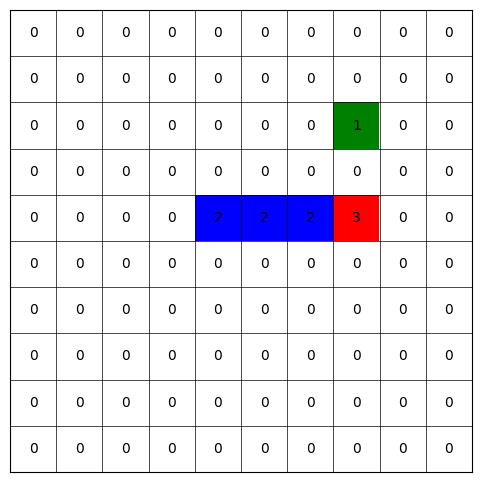

In [107]:
state, reward, done, _ = snake.step(0)
print(state)
print("Reward", reward)
print("Done", done)

visualize_game_state(state)